# Load Dependencies

In [3]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd

In [4]:
# Create function to segment avalanche events and calculate size and duration

def avalancheDist_mult(data,thresh,t):
    st=[]
    en=[]
    dt=np.zeros(t.size)
    dt[1:]=t[1:]-t[:-1]
    for i in range (data.size):
        if len(st)==len(en):
            if data[i]>thresh:
                st.append(i)
            continue
        if len(st)>len(en):
            if data[i]<thresh:
                en.append(i)
    if len(st)>len(en):
        en.append(data.size-1)
    st=np.array(st)
    en=np.array(en)
    print(st.shape)
    T=t[en]-t[st]
    S=np.zeros(T.size)
    for i in range (st.size):
        S[i]=np.sum((data[st[i]:en[i]]-thresh)*dt[st[i]:en[i]]) 
    return T,S

In [6]:
def averageAvalancheShape(x,spec,s,num,sh):
    times=[]
    vals=[]
    x_shift=x
    st,en=avalancheLoc(x_shift,0)
    tem1,tem2=extractInterpolatedAvalanches(st,en,x_shift[:],s,num)
    times.extend(tem1)
    vals.extend(tem2)
    CURVE=binAvg(times,vals,np.linspace(0,1,num))
    CURVE=CURVE-np.min([CURVE[0],CURVE[-1]])
    CURVE=CURVE/np.mean(CURVE)
    return CURVE


def avalancheLoc(data,thresh):
    st=[]
    en=[]
    for i in range (data.size):
        if len(st)==len(en):
            if data[i]>thresh:
                st.append(i)
            continue
        if len(st)>len(en):
            if data[i]<thresh:
                en.append(i)
    if len(st)>len(en):
        en.append(data.size-1)
    st=np.array(st)
    en=np.array(en)
    return st,en

def binAvg(x,y,bi=np.linspace(0,1,10)):
    n1=np.histogram(x,bins=bi)[0]
    n2=np.histogram(x,bins=bi,weights=y)[0]
    return np.array(n2)/np.array(n1)

def extractInterpolatedAvalanches(st,en,data,s,num=100):
    d=en-st
    t=np.array([])
    curve=np.array([])
    t_inter=np.linspace(0,1,num)
    for i in range (d.size):
        if d[i]>=s[0] and d[i]<=s[1]:
            t_this=np.linspace(0,1,d[i])
            y_this=data[st[i]:en[i]]
            yFunc=scipy.interpolate.interp1d(t_this,y_this,kind='quadratic')
            y_this=yFunc(t_inter)
            y_this=y_this/np.mean(y_this)
            curve=np.append(curve,y_this)
            t=np.append(t,t_inter)
    return t,curve


# Timeseries Processing

In [7]:
# Load Data ##

time_df = pd.read_csv('BTC-USD.csv')

time_df.head(5)


,Date,Open,High,Low,Close,Adj Close,Market Cap
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [8]:
closingprices = time_df['Close']

closearray = np.array(closingprices)
closearray.shape

t = np.arange(0, 2739, 1)

Text(0, 0.5, 'Closing Price (USD)')

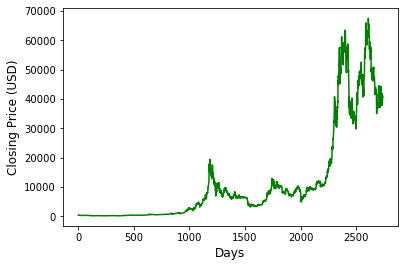

In [9]:
plt.plot(t, closearray, 'green')
plt.xlabel('Days', fontsize=12)
plt.ylabel('Closing Price (USD)', fontsize=12)

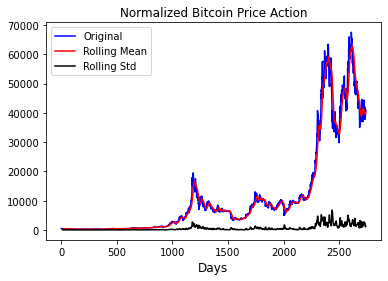

ADF Stastistic: -1.053238
p-value: 0.733356
The graph is non stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [10]:
# Create function to test for stationarity

def test_stationarity(x):
    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean() #rolling mean
    rolstd = x.rolling(window=12,center=False).std() #rolling stdev
    
    #Plot rolling statistics:
    orig = plt.plot(x, color='blue',label='Original') #plot closing price
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.xlabel('Days', fontsize=12)
    plt.legend(loc='best')
    plt.title('Normalized Bitcoin Price Action')
    plt.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))
        
        
test_stationarity(closingprices)

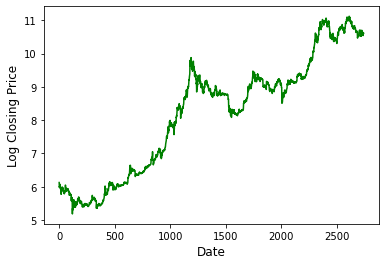

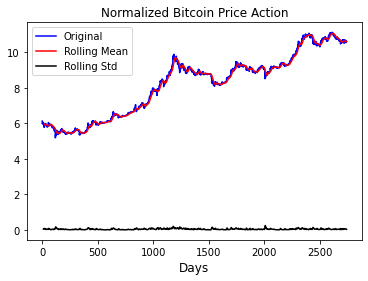

ADF Stastistic: -0.494491
p-value: 0.893087
The graph is non stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [11]:
#Log transformation

logbtc = np.log(closingprices)
plt.plot(logbtc,color="green")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Closing Price', fontsize=12)
plt.show()

test_stationarity(logbtc)

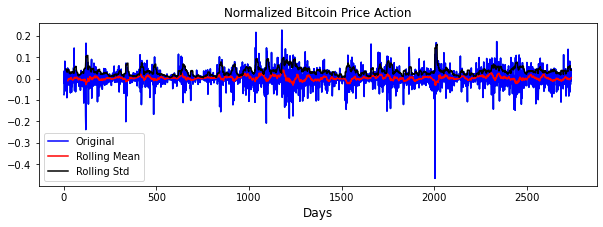

ADF Stastistic: -15.797884
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [12]:
fig = plt.figure(figsize=(10,3))
ts_log_diff = logbtc - logbtc.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

plt.show()


In [14]:
carray = np.array(ts_log_diff)
print(np.mean(carray))

0.0016396302516784743


# Quantifying Fluctuations

In [19]:

T=[]
S=[]
st=0

tem1,tem2=avalancheDist_mult(carray, 0.01,t)  #switch to 1 times mean for everything but plankton
T.append(tem1)
S.append(tem2)



(604,)


In [16]:
T

[array([ 1,  1,  1,  4,  3,  1,  1,  1,  1,  2,  2,  1,  1,  1,  2,  1,  1,
         1,  1,  2,  1,  1,  1,  3,  1,  1,  2,  2,  3,  2,  2,  3,  1,  2,
         1,  1,  3,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1,  2,  1,  1,
         1,  2,  2,  1,  1,  1,  1,  2,  1,  1,  2,  2,  1,  3,  1,  1,  1,
         1,  1,  1,  2,  2,  1,  3,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,
         1,  4,  4,  1,  1,  1,  2,  1,  3,  2,  1,  2,  1,  2,  1,  2,  1,
         1,  1,  1,  1,  1,  2,  1,  1,  1,  3,  3,  1,  1,  2,  1,  1,  1,
         1,  3,  2,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  3,  2,  2,  1,
         1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  2,  1,  1,  1,  1,  1,  2,
         1,  2,  1,  1,  1,  1,  1,  2,  3,  1,  4,  3,  4,  2,  2,  1,  1,
         1,  5,  2,  1,  1,  2,  2,  1,  2,  3,  1,  2,  3,  1,  1,  1,  2,
         1,  1,  1,  1,  1,  4, 12,  1,  4,  3,  2,  4,  2,  1,  1,  1,  2,
         2,  1,  1,  3,  1,  1,  2,  1,  1,  2,  2,  3,  2,  5,  1,  3,  1,
         2, 

In [17]:
S

[array([2.51112396e-02, 7.03325897e-02, 2.01093686e-02, 9.00550783e-02,
        7.11673046e-02, 9.82518538e-03, 1.11782236e-02, 3.02847373e-03,
        1.85348986e-02, 3.53200831e-02, 4.01968415e-02, 1.31443744e-01,
        2.07583477e-02, 4.17681381e-03, 4.57411170e-02, 8.16649223e-03,
        9.42568211e-03, 1.88475552e-03, 2.17735596e-03, 3.78938928e-02,
        2.38396279e-02, 1.75657395e-02, 1.99770219e-02, 7.80378964e-02,
        1.46074465e-02, 1.54002351e-01, 5.53807907e-02, 7.94295315e-02,
        1.30683871e-01, 7.11990702e-02, 2.78573837e-02, 1.30408274e-01,
        3.09186314e-02, 1.10498812e-02, 2.27719475e-03, 6.10216427e-02,
        7.24805960e-02, 1.23684660e-03, 2.88942164e-03, 4.41055563e-02,
        5.70745319e-03, 1.04243962e-02, 7.89976709e-03, 2.00599249e-02,
        1.30849997e-02, 9.63596803e-03, 1.53234383e-02, 1.68382942e-02,
        2.20581453e-02, 3.62926995e-02, 3.39368677e-02, 3.47609638e-02,
        1.50516775e-02, 3.94755962e-02, 1.10396541e-02, 2.823055

# Avalanche Analysis

<function matplotlib.pyplot.show(close=None, block=None)>

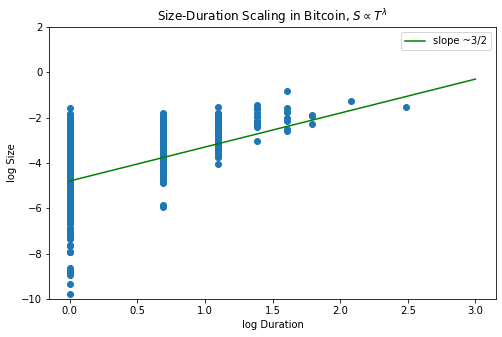

In [20]:
## Size-Duration Scaling ##

logT = []
logS = []

for ele in T:
    logT.append(np.log(ele))

for ele in S:
    logS.append(np.log(ele))
    
fig = plt.figure(figsize=(8,5))    
plt.scatter(logT, logS)
plt.xlabel('log Duration')
plt.ylabel('log Size')
plt.title('Size-Duration Scaling in Bitcoin, $S \propto T^{\lambda}$')

x = np.linspace(0,3)

plt.plot(x, (3/2)*(x)-4.8, '-g', label='slope ~3/2')
plt.legend()
plt.ylim(-10,2)
plt.show

In [42]:
def sizedurscaler(T, S):
    bi = np.logspace(0,4,100)
    n1, b, p = plt.hist((T), bins= bi)
    n2, b, p = plt.hist((T), bins=bi, weights = S)
    plt.close('all')
    fig = plt.figure()
    plt.scatter(np.log10(b[1:]), np.log10(n2/n1), alpha=1, color='darkorange')
    plt.scatter(np.log10(T), np.log10(S), zorder=1, color='grey', edgecolor='None', alpha =1) #rasterized=True)
    x = np.linspace(0,1.2)
    plt.plot(x, (1.5)*(x)-2, '-r', label='slope ~3/2')
    plt.ylabel('Log Average Size, log[S]')
    plt.xlabel('Log Duration, logT')
    plt.ylim(-5,1)
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


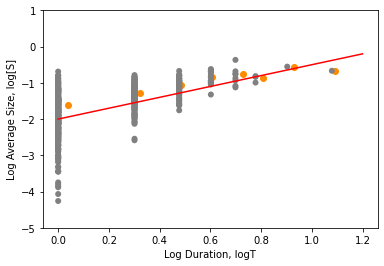

In [43]:
sizedurscaler(T,S)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


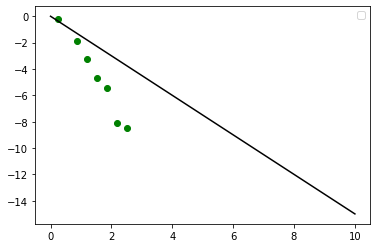

In [24]:
# T v Freq


bi = np.logspace(-4,10,100)
n,b,p = plt.hist(T, bins=bi)
bx = (bi[1:])-(bi[:-1])
bx[np.where(bx==0)]=1
n = n/bx
n = n/np.sum(n)
plt.close('all')
plt.scatter(np.log(bi[1:]), np.log(n), color='green')
plt.legend()

b = np.linspace(0,10)
plt.plot(b, b*-3/2, color='black')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


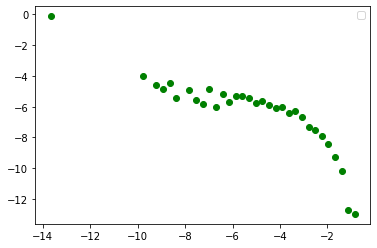

In [21]:
# S v Freq


bi = np.logspace(-8,4,100)
n,b,p = plt.hist(S, bins=bi)
bx = (bi[1:])-(bi[:-1])
bx[np.where(bx==0)]=1
n = n/bx
n = n/np.sum(n)
plt.close('all')
plt.scatter(np.log(bi[1:]), np.log(n), color='green')
plt.legend()

#b = np.linspace(-10,0)
#plt.plot(b, b*-1, color='black')

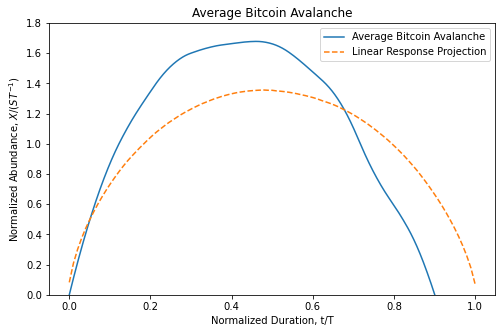

In [20]:
import scipy.interpolate
lincurve = np.load('normShape.npy')



times=[]
vals=[]
spec=[1] #change to what species are there for other datasets
s=[3,100]
num=10000
sh=1
CURVE = averageAvalancheShape(carray,spec,s,num=num,sh=sh)

fig=plt.figure(figsize=(8,5))
plt.plot(np.linspace(0,1,CURVE.size),CURVE, label='Average Bitcoin Avalanche')
plt.plot(np.linspace(0,1,lincurve.size),lincurve, label='Linear Response Projection', linestyle='--')
plt.xlabel('Normalized Duration, t/T')
plt.ylim(0,1.8)
plt.ylabel('Normalized Abundance, $X/(ST^{-1})$')
plt.title('Average Bitcoin Avalanche')
plt.legend()
plt.show()
np.save('BTC-average.npy',CURVE)



